In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("../../dataset/cleaned_bank.csv", delimiter=',')
data.info()

# Separate target from the features
X = data.copy()
y = X.pop("y")  # target feature

# One-hot encoding for categorical variables
data = pd.get_dummies(data, columns=['contact'], drop_first=False) # Drop_first=False keeps all categories

# Check if all discrete features are integers
discrete_features = X.dtypes.apply(lambda dtype: np.issubdtype(dtype, np.integer))

print(data.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2403 entries, 0 to 2402
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        2403 non-null   int64  
 1   job        2403 non-null   object 
 2   marital    2403 non-null   object 
 3   education  2403 non-null   object 
 4   default    2403 non-null   object 
 5   balance    2403 non-null   float64
 6   housing    2403 non-null   object 
 7   loan       2403 non-null   object 
 8   contact    2403 non-null   object 
 9   day        2403 non-null   int64  
 10  month      2403 non-null   object 
 11  duration   2403 non-null   int64  
 12  campaign   2403 non-null   int64  
 13  pdays      2403 non-null   int64  
 14  previous   2403 non-null   int64  
 15  poutcome   2403 non-null   object 
 16  y          2403 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 319.3+ KB
Index(['age', 'job', 'marital', 'education', 'default', 'balance', '

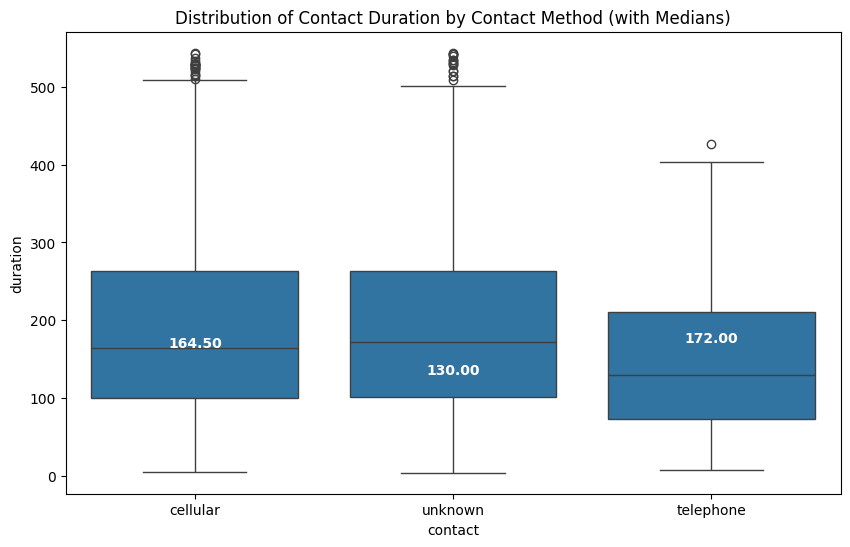

In [27]:
import seaborn as sns

# Create the box plot
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='contact', y='duration', data=X)

# Calculate medians for each contact method
medians = X.groupby(['contact'])['duration'].median()

# Add median values as text labels on the plot
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', horizontalalignment='center', color='white', weight='semibold')

# Set the title and show the plot
plt.title('Distribution of Contact Duration by Contact Method (with Medians)')
plt.show()



In [28]:
import scipy.stats as stats

# Perform a test to check if duration varies by contact method
anova_result = stats.f_oneway(X[X['contact'] == 'cellular']['duration'],
                              X[X['contact'] == 'telephone']['duration'],
                              X[X['contact'] == 'unknown']['duration'])

print(' F-statistic:', anova_result.statistic)
print(' p-value:', anova_result.pvalue)


 F-statistic: 8.903472492798652
 p-value: 0.00014045757931595678


F-statistic: Measures how different the means are across the groups. A larger value indicates more variance between groups. The value in our case is relatively high which means that duration varies across different contact methods.
p-value: The p-value is less than 0.005 that suggests that there are significant differences in the duration across different contact methods.

Conclusion:
Distribution diagram as well as F-statistic and p-value shows that contact method impacts the duration of the call.

In [29]:
# Create interaction features between 'duration' and one-hot encoded contact columns
data['duration_contact_cellular'] = data['duration'] * data['contact_cellular']
data['duration_contact_telephone'] = data['duration'] * data['contact_telephone']
data['duration_contact_unknown'] = data['duration'] * data['contact_unknown']

# Calculate the median duration for each contact method
# For each one-hot encoded contact type, calculate the median of 'duration'
median_cellular = data[data['contact_cellular'] == 1]['duration'].median()
median_telephone = data[data['contact_telephone'] == 1]['duration'].median()
median_unknown = data[data['contact_unknown'] == 1]['duration'].median()

# Create the 'above_median_duration' feature based on one-hot encoded contact types
data['above_median_duration'] = data.apply(
    lambda row: 1 if (
        (row['contact_cellular'] == 1 and row['duration'] > median_cellular) or
        (row['contact_telephone'] == 1 and row['duration'] > median_telephone) or
        (row['contact_unknown'] == 1 and row['duration'] > median_unknown)
    ) else 0, axis=1
)
print(data.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'duration_contact_cellular',
       'duration_contact_telephone', 'duration_contact_unknown',
       'above_median_duration'],
      dtype='object')


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = pd.get_dummies(X, drop_first=True)

# Split the dataset into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model with the new features
model_with_new_features = RandomForestClassifier(random_state=42)
model_with_new_features.fit(X_train_new, y_train_new)

# Make predictions on the test set
y_pred_new = model_with_new_features.predict(X_test_new)

# Evaluate model performance
print("Model Performance with New Features:")
print("Accuracy:", accuracy_score(y_test_new, y_pred_new))
print(classification_report(y_test_new, y_pred_new))


Model Performance with New Features:
Accuracy: 0.9625779625779626
              precision    recall  f1-score   support

          no       0.96      1.00      0.98       461
         yes       1.00      0.10      0.18        20

    accuracy                           0.96       481
   macro avg       0.98      0.55      0.58       481
weighted avg       0.96      0.96      0.95       481



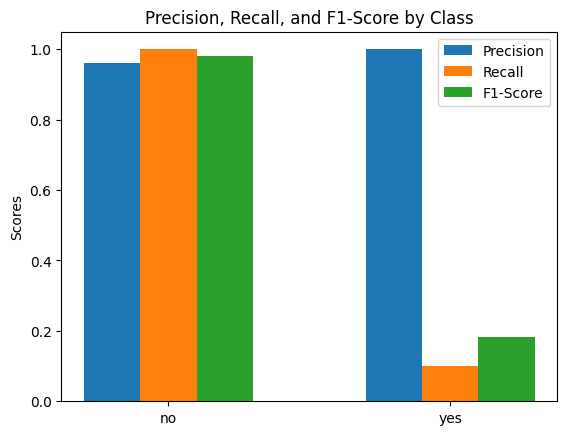

In [31]:
import numpy as np

# Classification report data
metrics = classification_report(y_test_new, y_pred_new, output_dict=True)

# Extract metrics for each class
precision = [metrics['no']['precision'], metrics['yes']['precision']]
recall = [metrics['no']['recall'], metrics['yes']['recall']]
f1_score = [metrics['no']['f1-score'], metrics['yes']['f1-score']]

# Class labels
labels = ['no', 'yes']

# Plot bar chart
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-Score')

# Add some labels
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [32]:
# Normalize/scale 'balance' (optional: this helps to ensure balance values are comparable with other features)
data['scaled_balance'] = (data['balance'] - data['balance'].min()) / (data['balance'].max() - data['balance'].min())

# Assign penalties for having loans and default status
data['housing_penalty'] = data['housing'].apply(lambda x: -1 if x == 'yes' else 0)
data['loan_penalty'] = data['loan'].apply(lambda x: -1 if x == 'yes' else 0)
data['default_penalty'] = data['default'].apply(lambda x: -2 if x == 'yes' else 0)

# Assign job scores (higher for high-income jobs)
job_scores = {
    'management': 2, 'entrepreneur': 2, 'self-employed': 1, 'technician': 1,
    'services': 0, 'admin.': 0, 'student': 1, 'blue-collar': -1,
    'unemployed': -2, 'retired': -1, 'housemaid': -1, 'unknown': 0
}
data['job_score'] = data['job'].map(job_scores)

# Create the Financial Stability Index (FSI)
data['FSI'] = (data['scaled_balance'] + data['job_score']
               + data['housing_penalty'] + data['loan_penalty'] + data['default_penalty'])

# Now the FSI has been added to the dataset as a new column

# Show the first few rows including FSI
print(data[['balance', 'housing', 'loan', 'default', 'job', 'FSI']].head())

data.to_csv('dataset_with_FSI.csv', index=False)
data


   balance housing loan default           job       FSI
0   1787.0      no   no      no    unemployed -1.160932
1   1476.0     yes  yes      no    management  0.754809
2      0.0     yes   no      no   blue-collar -1.645083
3    147.0     yes   no      no    technician  0.394744
4    221.0     yes   no      no  entrepreneur  1.414793


,age,job,marital,education,default,balance,housing,loan,day,month,...,duration_contact_cellular,duration_contact_telephone,duration_contact_unknown,above_median_duration,scaled_balance,housing_penalty,loan_penalty,default_penalty,job_score,FSI
0,30,unemployed,married,primary,no,1787.0,no,no,19,oct,...,79,0,0,0,0.839068,0,0,0,-2,-1.160932
1,30,management,married,tertiary,no,1476.0,yes,yes,3,jun,...,0,0,199,1,0.754809,-1,-1,0,2,0.754809
2,59,blue-collar,married,secondary,no,0.0,yes,no,5,may,...,0,0,226,1,0.354917,-1,0,0,-1,-1.645083
3,39,technician,married,secondary,no,147.0,yes,no,6,may,...,151,0,0,0,0.394744,-1,0,0,1,0.394744
4,41,entrepreneur,married,tertiary,no,221.0,yes,no,14,may,...,0,0,57,0,0.414793,-1,0,0,2,1.414793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,33,services,married,secondary,no,288.0,yes,no,17,apr,...,306,0,0,1,0.432945,-1,0,0,0,-0.567055
2399,42,admin.,married,unknown,no,642.0,yes,yes,16,may,...,0,0,509,1,0.528854,-1,-1,0,0,-1.471146
2400,36,technician,divorced,secondary,no,566.0,yes,no,20,may,...,0,0,129,0,0.508263,-1,0,0,1,0.508263
2401,49,blue-collar,married,secondary,no,322.0,no,no,14,aug,...,356,0,0,1,0.442157,0,0,0,-1,-0.557843
